In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram
from networkx.algorithms import community, centrality, components

<class 'networkx.classes.graph.Graph'>


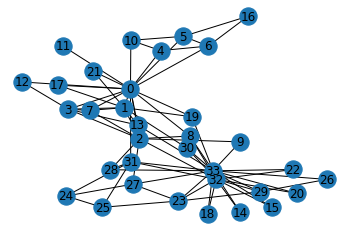

In [2]:
# get graph
G = nx.karate_club_graph()
print(type(G))
pos = nx.spring_layout(G)
labels=nx.draw_networkx_labels(G,pos=pos)
nx.draw(G, pos)

### Graph Summary
1. Connectedness
2. Modularity: higher the value, the more easy to break the graph to clusters
3. Degree Distribution: visualisation
4. Power law: degree inequality of nodes

In [3]:
def report_connectedness(G, save_img_path=None):
    """
        Checks if the graph is connected
        and returns the connected components
        if the graph is disconnected
        
        G (nx.Graph): graph for which the 
                top nodes must be determined.
                
        save_img_path (str): path to save visualisation
                of the components detected.
        
        Returns:
            True: if the given graph is connected.
            
            False, connected_components: if the graph
                is disconnected along with list of sets of
                nodes representing the components.
    """
    # aggregrate connectedness metrics
    is_connected = components.is_connected(G)
    
    # get the connected components if the graph is disconnected
    connected_components = list(components.connected_components(G))

    # save the disconnected components visualisation if the path given
    if save_img_path:
        colors = np.linspace(0, 1, len(connected_components))
        com_color_map = dict()
        for idx, com in enumerate(connected_components):
            for node in com:
                com_color_map[node] = colors[idx]

        labels=nx.draw_networkx_labels(G,pos=pos)
        nx.draw(G, pos, node_color=list(com_color_map.values()))
        plt.savefig(save_img_path, format="PNG")
    
        return (is_connected, connected_components)

(True,
 [{0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33}])

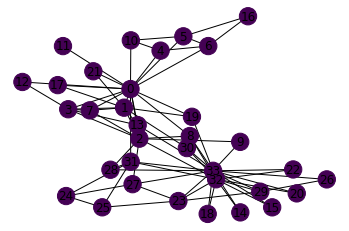

In [4]:
report_connectedness(G, save_img_path="connected_components.png")

### Top Nodes

node centrality mesures

In [5]:
def top_nodes(G, k=3):
    """
        Returns the top k nodes for various
        centrality measures: degree, 
        betweennes and closeness.
        
        Args:
            G (nx.Graph): graph for which the 
                top nodes must be determined.
            
            k (int): number of top nodes to return.
                if set to -ve, all the nodes will be
                returned.
            
        Returns:
            res_dict (dict): dictionary of each centrality
                measure with list of top k nodes in that 
                measure as values to the dictionary.
    """
    # number of nodes in the graph each node is connected to
    node_deg_dict = centrality.degree_centrality(G)
    # number of all pair shortest paths that pass through each node
    node_btw_dict = centrality.betweenness_centrality(G)
    # number of neighbours connected to each other for each node
    node_clo_dict = centrality.closeness_centrality(G)
    
    # sort by nodes by each centrality measure
    top_k_deg_nodes = sorted(node_deg_dict.items(), key = lambda x: x[1])
    top_k_btw_nodes = sorted(node_btw_dict.items(), key = lambda x: x[1])
    top_k_clo_nodes = sorted(node_clo_dict.items(), key = lambda x: x[1])
    
    # pick the top k nodes
    if k > 0:
        res = (top_k_deg_nodes[-k:], top_k_btw_nodes[-k:], top_k_clo_nodes[-k:])
    else:
        res = (top_k_deg_nodes[::-1], top_k_btw_nodes[::-1], top_k_clo_nodes[::-1])
    
    # format and return the top nodes for each centrality 
    res_dict = dict()
    res_dict["node_degree"] = list(zip(*res[0]))[0]
    res_dict["node_betweenness"] = list(zip(*res[1]))[0]
    res_dict["node_closeness"] = list(zip(*res[2]))[0]
    return res_dict

In [6]:
top_nodes(G, 5)

{'node_degree': (1, 2, 32, 0, 33),
 'node_betweenness': (31, 2, 32, 33, 0),
 'node_closeness': (32, 31, 33, 2, 0)}

### Top Edges

In [7]:
def top_edges(G, k=3):
    """
        Returns the top k edges for various
        centrality measures: betweenness,
        information flow and relation type count.
        
        Args:
            G (nx.Graph): graph for which the 
                top nodes must be determined.
            
            k (int): number of top edges to return.
                if set to -ve, all the edges will be
                returned.
            
        Returns:
            res_dict (dict): dictionary of each centrality
                measure with list of top k edges in that 
                measure as values to the dictionary.
    """
    # number of all pair shortest paths that pass through each edge
    edge_btw_dict = centrality.edge_betweenness_centrality(G)
    # ability for information flow for each edge
    edge_cur_dict = centrality.edge_current_flow_betweenness_centrality(G)
    
    
    # sort by nodes by each centrality measure
    top_k_btw_edges = sorted(edge_btw_dict.items(), key = lambda x: x[1])
    top_k_cur_edges = sorted(edge_cur_dict.items(), key = lambda x: x[1])
    
    # pick the top k edges
    if k > 0:
        res = (top_k_btw_edges[-k:], top_k_cur_edges[-k:])
    else:
        res = (top_k_btw_edges[::-1], top_k_cur_edges[::-1])
    
    # format and return the top nodes for each centrality 
    res_dict = dict()
    res_dict["edge_betweeness"] = list(zip(*res[0]))[0]
    res_dict["edge_information_flow"] = list(zip(*res[1]))[0]
    return res_dict

In [8]:
top_edges(G, k=5)

{'edge_betweeness': ((0, 8), (0, 2), (0, 5), (0, 6), (0, 31)),
 'edge_information_flow': ((30, 1), (33, 13), (33, 19), (8, 0), (31, 0))}

### Community Detection

In [9]:
def detect_communities(G, save_img_path=None):
    """
        Returns the communities detected in the given
        graph using optimal modularity approach. 
        
        Args:
            G (nx.Graph): graph for which the 
                top nodes must be determined.
                
            save_img_path (str): path to save visualisation
                of the communities detected.
            
        Returns:
            communities (list): list of tuples of nodes representing
                communities detected.
    """
    # perform community detection using greedy modularity approach
    _coms = community.greedy_modularity_communities(G)
    communities = [list(c) for c in _coms]
    
    # save image if path given
    if save_img_path:
        colors = np.linspace(0, 1, len(communities))

        com_color_map = dict()
        for idx, com in enumerate(communities):
            for node in com:
                com_color_map[node] = colors[idx]
        
        labels=nx.draw_networkx_labels(G,pos=pos)
        nx.draw(G, pos, node_color=list(com_color_map.values()))
        plt.savefig(save_img_path, format="PNG")
    
    return communities

[[32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
 [1, 2, 3, 7, 9, 12, 13, 17, 21],
 [0, 4, 5, 6, 10, 11, 16, 19]]

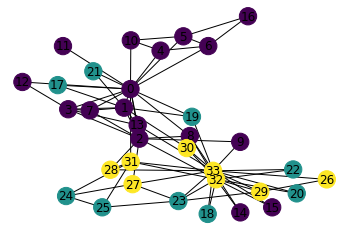

In [10]:
detect_communities(G, save_img_path="test.png")

### Hierarchal Clustering

In [11]:
def hierarchal_clustering(G, save_img_path=None):
    """
        Perform hierarchal clustering on a given graph
        using the Girvan-Newman algorithm and visualise
        if path given.
        
        G (nx.Graph): graph for which the 
                top nodes must be determined.
        
        save_img_path (str): path to save visualisation
                of the communities detected.
        
        Returns:
            communities (list): hierarchy of clusters as list
                with the index referring to each stage of clustering.
    """
    # obtain hierarchal clusters using the Girvan-Newman Algorithm
    communities = list(nx.community.girvan_newman(G))
    
    if save_img_path:

        # building initial dict of node_id to each possible subset:
        node_id = 0
        init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
        for comm in communities:
            for subset in list(comm):
                if subset not in init_node2community_dict.values():
                    node_id += 1
                    init_node2community_dict[node_id] = subset

        # turning this dictionary to the desired format in @mdml's answer
        node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
        for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
            for node_id_parent, group in init_node2community_dict.items():
                if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
                    node_id_to_children[node_id_parent].append(node_id1)
                    node_id_to_children[node_id_parent].append(node_id2)

        # also recording node_labels dict for the correct label for dendrogram leaves
        node_labels = dict()
        for node_id, group in init_node2community_dict.items():
            if len(group) == 1:
                node_labels[node_id] = list(group)[0]
            else:
                node_labels[node_id] = ''

        # also needing a subset to rank dict to later know within all k-length merges which came first
        subset_rank_dict = dict()
        rank = 0
        for e in communities[::-1]:
            for p in list(e):
                if tuple(p) not in subset_rank_dict:
                    subset_rank_dict[tuple(sorted(p))] = rank
                    rank += 1
        subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

        # my function to get a merge height so that it is unique (probably not that efficient)
        def get_merge_height(sub):
            sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
            n = len(sub_tuple)
            other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
            min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
            range = (max_rank-min_rank) if max_rank > min_rank else 1
            return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

        # finally using @mdml's magic, slightly modified:
        G           = nx.DiGraph(node_id_to_children)
        nodes       = G.nodes()
        leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
        inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

        # Compute the size of each subtree
        subtree = dict( (n, [n]) for n in leaves )
        for u in inner_nodes:
            children = set()
            node_list = list(node_id_to_children[u])
            while len(node_list) > 0:
                v = node_list.pop(0)
                children.add( v )
                node_list += node_id_to_children[v]
            subtree[u] = sorted(children & leaves)

        inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

        # Construct the linkage matrix
        leaves = sorted(leaves)
        index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
        Z = []
        k = len(leaves)
        for i, n in enumerate(inner_nodes):
            children = node_id_to_children[n]
            x = children[0]
            for y in children[1:]:
                z = tuple(sorted(subtree[x] + subtree[y]))
                i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
                Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
                index[z] = k
                subtree[z] = list(z)
                x = z
                k += 1

        # dendrogram
        dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])

        # save the dendogram
        plt.savefig(save_img_path, format='PNG')
        
    return communities

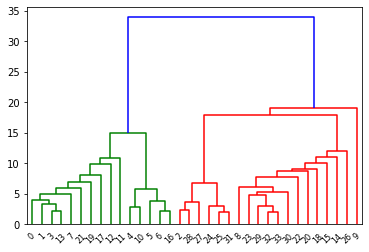

In [12]:
hc = hierarchal_clustering(G, save_img_path='hc.png')

### Including the relation types in the SNA

In [13]:
# add relation types to the graph
rel_types = ['work_together', 'contact', 'oppose', 'like', 'part_of']
relations = [(u, v, rel_types[np.random.randint(0, 5)]) for (u, v) in G.edges]
relG = nx.Graph()
[relG.add_edge(u, v, relation=r) for u, v, r in relations]
list(relG.edges.data())[:5]

[(0, 1, {'relation': 'work_together'}),
 (0, 2, {'relation': 'part_of'}),
 (0, 3, {'relation': 'like'}),
 (0, 4, {'relation': 'work_together'}),
 (0, 5, {'relation': 'contact'})]

### Node Summary

In [14]:
def summarise_nodes(relG):
    """
        Creates summaries for all nodes
        in a given graph with the following
        attributes:
        1. degree
        2. neighbours
        3. top relation types
        
        Args:
            relG (nx.Graph): graph for which
                the summary must be created.
                
            Note: the edges in relG must have
            'relation' edge attribute referring
            to the relation type.
        
        Returns:
            summaries (dict): dictionary of nodes
                with the string summaries as values.
    """
    summaries = dict()
    for n in relG.nodes:
        # determine the key info
        neighbors = list(relG.neighbors(n))
        rels_of_node = dict()
        for i in neighbors:
            if relG[n][i]['relation'] not in rels_of_node.keys():
                rels_of_node[relG[n][i]['relation']] = [i]
            else:
                rels_of_node[relG[n][i]['relation']].append(i)
        
        # create summary
        summaries[n] = f"degree: {len(neighbors)}\n"
        if len(neighbors):
            summaries[n] += f"Relations: \n"
            for k, v in rels_of_node.items():
                v_str = ", ".join([str(j) for j in v])
                summaries[n] += f"'{k}' ({len(v)}) - {v_str}\n"
        
    return summaries

In [15]:
for n, s in list(summarise_nodes(relG).items())[:2]:
    print(f"summaries[{n}]: \n{s}")

summaries[0]: 
degree: 16
Relations: 
'work_together' (5) - 1, 4, 11, 21, 31
'part_of' (3) - 2, 8, 12
'like' (1) - 3
'contact' (3) - 5, 13, 19
'oppose' (4) - 6, 7, 10, 17

summaries[1]: 
degree: 9
Relations: 
'work_together' (5) - 0, 3, 7, 19, 30
'oppose' (2) - 2, 21
'like' (1) - 13
'part_of' (1) - 17



### Cluster Summary

In [18]:
def summarise_communities(relG):
    """
        Creates summaries for all clusters
        in a given graph with the following
        attributes:
        1. bridges - node with the highest betweeness
        2. members
        3. Closeness - how close the group (higher, closer)
        4. relation counts in the cluster

        Args:
            relG (nx.Graph): graph for which
                the summary must be created.

            Note: the edges in relG must have
            'relation' edge attribute referring
            to the relation type.

        Returns:
            summaries (dict): dictionary of clusters
                with the string summaries as values.
    """
    # get communities
    communities = list(enumerate(detect_communities(relG)))
    node_comm_dict = dict()
    for i, c in communities:
        for u in c:
            node_comm_dict[u] = i
    
    # get bridges: nodes in clusters in highest betweenness centrality
    node_btw_dict = centrality.betweenness_centrality(relG)
    comm_bridge_dict = {i:(None, -1) for i in range(len(communities))}
    for n, b in node_btw_dict.items():
        c = node_comm_dict[n]
        if b > comm_bridge_dict[c][1]:
            comm_bridge_dict[c] = (n, b)

    # get powers of clusters
    comm_graph_dict = {i: nx.Graph() for i, c in communities}
    for (u, v, r) in relG.edges.data('relation'):
        uc, vc = node_comm_dict[u], node_comm_dict[v]
        if uc == vc:
            comm_graph_dict[uc].add_edge(u, v, relation=r)
    
    # get average closeness centrality
    comm_avg_clo_dict = dict()
    for i, G in comm_graph_dict.items():
        node_clo_dict = centrality.closeness_centrality(G)
        s, n = sum(list(node_clo_dict.values())), len(node_clo_dict)
        comm_avg_clo_dict[i] = s / n
        
    # get relation counts for each cluster
    rel_count_comm_dict = dict()
    for i, c in comm_graph_dict.items():
        u, v, r = list(zip(*c.edges.data('relation')))
        rels, counts = np.unique(r, return_counts=True)
        rel_count_comm_dict[i] = list(zip(rels, counts))
    
    # create string summary for each cluster 
    summaries = dict()
    for i, c in communities:
        summaries[i] = f"Bridge: {comm_bridge_dict[i][0]}\n"
        members = ", ".join([str(x) for x in c])
        summaries[i] += f"Members: {members}\n"
        closeness = np.around(comm_avg_clo_dict[i], decimals=4)
        summaries[i] += f"Closeness: {closeness}\n"
        rel_counts = ['\'' + r + '\'- ' + str(c) for r, c in rel_count_comm_dict[i]]
        summaries[i] += "Relations:\n" + "\n".join(rel_counts)

    return summaries

In [19]:
comm_summaries = summarise_communities(relG)
for k, v in comm_summaries.items():
    print(f"summaries[{k}]")
    print(v)
    print()

summaries[0]
Bridge: 33
Members: 32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
Closeness: 0.5505
Relations:
'contact'- 9
'like'- 8
'oppose'- 5
'part_of'- 5
'work_together'- 7

summaries[1]
Bridge: 2
Members: 1, 2, 3, 7, 9, 12, 13, 17, 21
Closeness: 0.5906
Relations:
'contact'- 2
'like'- 2
'oppose'- 3
'part_of'- 3
'work_together'- 3

summaries[2]
Bridge: 0
Members: 0, 4, 5, 6, 10, 11, 16, 19
Closeness: 0.631
Relations:
'contact'- 3
'like'- 1
'oppose'- 2
'part_of'- 3
'work_together'- 3

